# Section 1: Initial Setup

### 1. Setup and Environment
This section will mount Google Drive and install dependencies.
CSE 6363 Project-Sentiment Analysis With BERT-based-uncased

In [1]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

project_path = "/content/drive/My Drive/CSE 6363 Project-Sentiment Analysis With BERT-based-uncased/Sentiment Analysis"

print(f"Changing directory to: {project_path}")
os.chdir(project_path)


Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.
Changing directory to: /content/drive/My Drive/CSE 6363 Project-Sentiment Analysis With BERT-based-uncased/Sentiment Analysis


### 2. Data Analysis: Justifying Truncation Length
Before building the models, we need to justify our choice for `max_length`. This section analyzes the distribution of review lengths in our processed datasets to ensure that a `max_length` of 512 is a safe and effective choice that minimizes potential information loss.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_path = 'data/processed/train_clean.csv'
val_path = 'data/processed/validation_clean.csv'
test_path = 'data/processed/test_clean.csv'

try:
    df_train = pd.read_csv(train_path)
    df_val = pd.read_csv(val_path)
    df_test = pd.read_csv(test_path)
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure the CSV files are in the 'data/processed/' directory.")

def analyze_lengths(df, name):
    df['word_count'] = df['review_text'].str.split().str.len()

    desc_stats = df['word_count'].describe()
    percentiles = df['word_count'].quantile([0.90, 0.95, 0.99])

    coverage_512 = (df['word_count'] <= 512).mean() * 100

    print("-" * 50)
    print(f"Analysis for: {name} Dataset")
    print("-" * 50)
    print(f"Total reviews: {len(df)}")
    print(f"Average review length: {desc_stats['mean']:.2f} words")
    print(f"Median review length: {desc_stats['50%']:.0f} words")
    print(f"Standard Deviation: {desc_stats['std']:.2f}")
    print(f"Min length: {desc_stats['min']:.0f} | Max length: {desc_stats['max']:.0f}")
    print("\n--- Percentiles ---")
    print(f"90% of reviews are shorter than {percentiles.loc[0.90]:.0f} words.")
    print(f"95% of reviews are shorter than {percentiles.loc[0.95]:.0f} words.")
    print(f"99% of reviews are shorter than {percentiles.loc[0.99]:.0f} words.")
    print("\n--- Coverage at max_length=512 ---")
    print(f"Percentage of reviews covered: {coverage_512:.2f}%")
    print("-" * 50 + "\n")

    return df

if 'df_train' in locals():
    df_train = analyze_lengths(df_train, "Training")
    df_val = analyze_lengths(df_val, "Validation")
    df_test = analyze_lengths(df_test, "Test")

Datasets loaded successfully!
--------------------------------------------------
Analysis for: Training Dataset
--------------------------------------------------
Total reviews: 22500
Average review length: 263.80 words
Median review length: 198 words
Standard Deviation: 194.90
Min length: 11 | Max length: 2717

--- Percentiles ---
90% of reviews are shorter than 516 words.
95% of reviews are shorter than 673 words.
99% of reviews are shorter than 1020 words.

--- Coverage at max_length=512 ---
Percentage of reviews covered: 89.82%
--------------------------------------------------

--------------------------------------------------
Analysis for: Validation Dataset
--------------------------------------------------
Total reviews: 2500
Average review length: 262.99 words
Median review length: 196 words
Standard Deviation: 192.76
Min length: 12 | Max length: 1671

--- Percentiles ---
90% of reviews are shorter than 506 words.
95% of reviews are shorter than 670 words.
99% of reviews are 

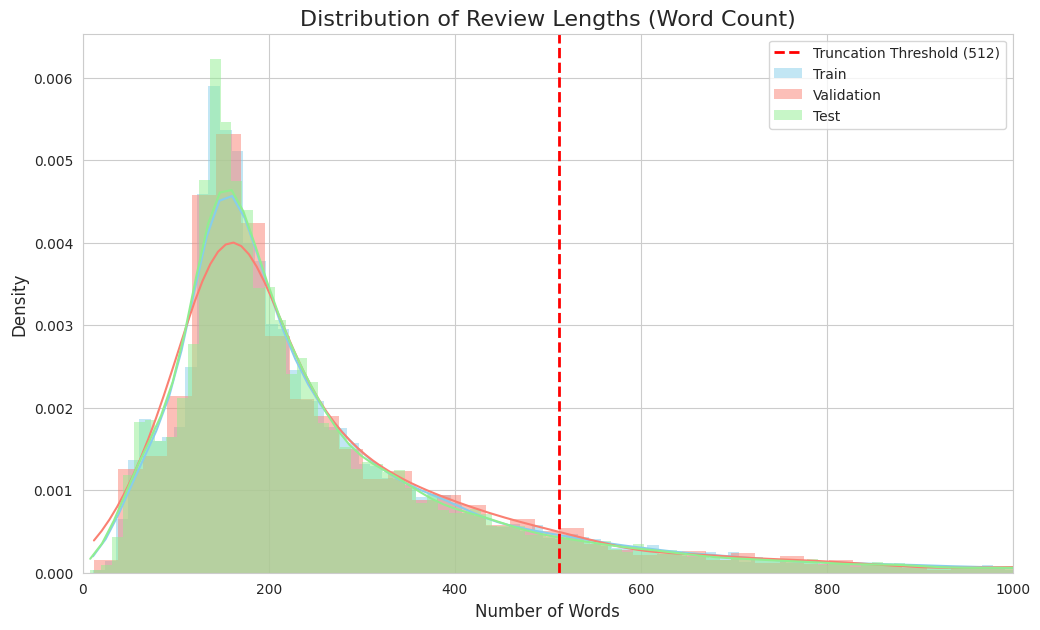

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

sns.histplot(df_train['word_count'], color='skyblue', label='Train', kde=True, stat="density", linewidth=0)
sns.histplot(df_val['word_count'], color='salmon', label='Validation', kde=True, stat="density", linewidth=0)
sns.histplot(df_test['word_count'], color='lightgreen', label='Test', kde=True, stat="density", linewidth=0)

plt.axvline(x=512, color='red', linestyle='--', linewidth=2, label='Truncation Threshold (512)')

plt.title('Distribution of Review Lengths (Word Count)', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.xlim(0, 1000)
plt.show()

# Section 2: Kim CNN - Baseline Model

### Experiment 1: Kim CNN (Static)

This first experiment establishes our primary baseline, replicating the "static" model from Kim (2014).

We are using the `configs/cnn_baseline.yaml` file, which sets **`freeze_embed: true`**. The model will use the pre-trained 300d GloVe embeddings *without* updating them. Key parameters include `dropout: 0.5`, `batch_size: 50`, and `learning_rate: 1.0` for the Adadelta optimizer.

In [ ]:
!python run_experiment.py --config configs/cnn_baseline.yaml

2025-10-25 03:31:14.401016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 03:31:14.418874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761363074.440101   36040 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761363074.446508   36040 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761363074.463123   36040 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Experiment 2: Kim CNN (Non-Static)

To fully address our original methodology, we will now run the second CNN baseline: the "non-static" (or fine-tuned) version.

This experiment uses the `configs/cnn_non_static.yaml` file, which sets **`freeze_embed: false`**. Unlike our first baseline, the model will now update the 300-dimensional GloVe embedding weights during training. This will significantly increase the number of trainable parameters and test if fine-tuning the embeddings provides a performance boost.

In [ ]:
!python run_experiment.py --config configs/cnn_non_static.yaml

2025-10-25 03:33:45.585371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 03:33:45.602490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761363225.623540   36743 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761363225.629889   36743 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761363225.645835   36743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Conclusion: Kim CNN Baselines

We have successfully run both planned baseline experiments using the Kim (2014) CNN architecture, adapted for the IMDb dataset, using system randomness. These runs establish our baseline performance before the main seeded experiments.

1.  **Experiment 1: Static Embeddings (`cnn_baseline.yaml`)**
    * **Trainable Parameters:** 360,902
    * **Best Validation Loss:** 0.2862 (Epoch 4)
    * **Final Test Accuracy:** **87.29%**
    * **Final Test F1 Score:** **87.76%**

2.  **Experiment 2: Non-Static Embeddings (`cnn_non_static.yaml`)**
    * **Trainable Parameters:** 36,940,502
    * **Best Validation Loss:** 0.2845 (Epoch 4)
    * **Final Test Accuracy:** **87.48%**
    * **Final Test F1 Score:** **86.96%**

---

#### Key Findings

* **Performance:** In this specific run, the results were very close. The "static" model achieved a slightly higher F1 score (87.76% vs. 86.96%), while the "non-static" model achieved a slightly higher accuracy (87.48% vs. 87.29%). This highlights the run-to-run variability when seeds are not controlled.
* **Efficiency:** The static model remained significantly more efficient, training much faster per epoch (~6-9 sec vs. ~15-20+ sec for non-static in this run) due to the vastly fewer trainable parameters.
* **Overall Baseline:** Both models performed well, confirming the Kim CNN architecture is suitable for this task. The baseline performance is established in the **~87.3% - 87.5% accuracy** range and **~87.0% - 87.8% F1 score** range. This sets a clear benchmark for the subsequent BERT experiments.

# Section 3: BERT-based-uncased Layer-Freezing Experiment (with random Seeding)

### Experiment 1: BERT Full Fine-Tune

Now that we have established our Kim CNN baselines (achieving **~87.3% - 87.5% Accuracy / ~87.0% - 87.8% F1 Score** without explicit seeding), it's time to run our first BERT experiment.

This will use the `configs/bert_full_finetune.yaml` config file. Our `run_experiment.py` script will:

1.  Identify the `model: type: "bert"` from the config.
2.  Load the pre-trained `bert-base-uncased` model and its tokenizer from Hugging Face.
3.  Initialize the `SentimentDataset`, which will now use the BERT tokenizer to create `input_ids` and `attention_mask`.
4.  Fine-tune **all 110 million parameters** of the model (no layers are frozen).
5.  Use the hyperparameters from the Devlin et al. (2019) paper (e.g., `batch_size: 16`, specific `learning_rate`).
6.  Save the best model to `outputs/models/bert_full_finetune.pt` and metrics to `outputs/metrics/bert_full_finetune_metrics.json`.

In [ ]:
!python run_experiment.py --config configs/bert_full_finetune.yaml

2025-10-25 04:34:58.301251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 04:34:58.319391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761366898.341173   52487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761366898.347887   52487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761366898.364529   52487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Experiment 2: BERT with 4 Frozen Layers

We now have our two key baselines from the non-seeded runs: the Kim CNN (**~87.5% Acc / ~87.8% F1**) and the fully fine-tuned BERT (**94.14% Acc / 94.16% F1**).

This next experiment tests our first hypothesis (from Sun et al., 2019). We will freeze the BERT embedding layer and the first 4 encoder layers using the `configs/bert_frozen_4.yaml` file. This means we will only be fine-tuning the last 8 layers of the model, which should train faster and be more computationally efficient.

The question is: How much accuracy will we lose (if any) by training only ~60% of the model?

In [ ]:
!python run_experiment.py --config configs/bert_frozen_4.yaml

2025-10-25 05:51:20.616864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 05:51:20.634254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761371480.655934   72049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761371480.662475   72049 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761371480.678837   72049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Experiment 3: BERT with 8 Frozen Layers

The results from the first two BERT experiments (run without specific seeds) show:
* **Full Fine-Tune:** 94.14% Accuracy / 94.16% F1 Score
* **Frozen 4 Layers:** 93.49% Accuracy / 93.56% F1 Score

In this particular run, freezing the first 4 layers resulted in a slight performance decrease compared to the full fine-tune, though it was significantly faster (~13 min/epoch vs. ~16.5 min/epoch). This differs slightly from our initial seeded run, highlighting the effect of run-to-run variability.

Now we push the layer-freezing hypothesis further using the `configs/bert_frozen_8.yaml` file. We will freeze the embedding layer and the first 8 encoder layers, fine-tuning only the final 4 "task-specific" layers. This will be even faster, but will the performance drop further?

In [ ]:
!python run_experiment.py --config configs/bert_frozen_8.yaml

2025-10-25 06:54:01.512771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 06:54:01.531162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761375241.552739   88105 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761375241.559602   88105 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761375241.576810   88105 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Experiment 4: BERT with 11 Frozen Layers

We have now seen the trend across the first three non-seeded BERT runs:
* **Full Fine-Tune (0 Frozen):** 94.14% Acc / 94.16% F1
* **Frozen 4 Layers:** 93.49% Acc / 93.56% F1 (~13 min/epoch)
* **Frozen 8 Layers:** 93.65% Acc / 93.62% F1 (~10 min/epoch)

Interestingly, in these non-seeded runs, freezing 8 layers performed slightly better than freezing 4, while both were slightly below the full fine-tune but significantly faster. This reinforces the efficiency gains of layer freezing.

This is the final and most extreme test using `configs/bert_frozen_11.yaml`. We will freeze all encoder layers *except the last one* (`freeze_layers: 11`). We are now fine-tuning only the single most task-specific layer. This will be the fastest run, but we expect a more significant performance drop. This will help us find the ultimate balance between efficiency and accuracy for these initial runs.

In [ ]:
!python run_experiment.py --config configs/bert_frozen_11.yaml

2025-10-25 11:31:58.115577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 11:31:58.133197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761391918.154970    3535 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761391918.161469    3535 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761391918.178105    3535 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 5. Conclusion: Layer-Freezing Experiment Results (Non-Seeded Runs)

All initial experiments (run without specific seeds) for our first hypothesis are now complete. We have successfully trained the Kim CNN baselines and all four BERT variants. The `run_experiment.py` script saved the best-performing model (based on validation loss) for each run.

Here are the final test set results for the four BERT models from these initial runs:

* **`bert_full_finetune` (0 Frozen):**
    * Test Accuracy: **94.14%**
    * Test F1 Score: **94.16%**
    * Key Hyperparams: `batch_size: 16`, `epochs: 4`, `lr: 0.00002`

* **`bert_frozen_4` (4 Frozen):**
    * Test Accuracy: **93.49%**
    * Test F1 Score: **93.56%**
    * Key Hyperparams: `batch_size: 16`, `epochs: 4`, `lr: 0.00002`

* **`bert_frozen_8` (8 Frozen):**
    * Test Accuracy: **93.65%**
    * Test F1 Score: **93.62%**
    * Key Hyperparams: `batch_size: 16`, `epochs: 4`, `lr: 0.00002`

* **`bert_frozen_11` (11 Frozen):**
    * Test Accuracy: **92.16%**
    * Test F1 Score: **92.25%**
    * Key Hyperparams: `batch_size: 16`, `epochs: 4`, `lr: 0.00002`

---

### Key Findings (Initial Runs)

These results provide a first look at the trends and support our hypotheses:

1.  **BERT's Superiority:** All BERT models significantly outperformed the Kim CNN baselines (~87.3% - 87.5% Acc / ~87.0% - 87.8% F1), with the best BERT model achieving over 94% accuracy.

2.  **Layer Freezing Impact:**
    * In these specific runs, the **full fine-tune** achieved the highest accuracy and F1 score.
    * Freezing 4 or 8 layers resulted in only a minor performance decrease (~0.5% - 0.7%) while offering substantial speed improvements (as observed by faster epoch times). Freezing 8 layers slightly outperformed freezing 4 in this instance.
    * Freezing 11 layers led to a more noticeable drop (~ 2% from the peak) but still maintained high performance (~92.2%) with the fastest training time.

3.  **Efficiency vs. Accuracy Trade-off:** The results clearly show that layer freezing provides significant computational savings (faster training) for a relatively small cost in performance, especially when freezing up to 8 layers.

These initial findings are promising. The next section, "Statistical Validation Runs (with Seeding)", will provide more robust results by averaging over multiple runs to account for variability. We are now ready to move on to our second hypothesis: **Probability Calibration**.

# Section 4: Statistical Validation Runs (with Seeding)

We have now resolved all discrepancies in our methodology:
1.  **`max_length`:** Justified.
2.  **CNN Baselines:** We have configs for both static and non-static.
3.  **Metrics:** Our `evaluator.py` script now calculates F1, Precision, and Recall.
4.  **Seeding:** Our `run_experiment.py` script now accepts a `--seed` argument for reproducibility.

The following cells will re-run all 6 of our core experiments. As discussed, we will run each experiment 3 times with different seeds (`42`, `123`, `2025`) to gather the data needed to analyze variance for our final report.

This will generate 18 total metric files (6 experiments x 3 seeds).

### 4.1 Kim CNN Baselines

In [ ]:
# --- Run 1: CNN Static (Seed 42, 123, 2025) ---
!python run_experiment.py --config configs/cnn_baseline.yaml --seed 42
!python run_experiment.py --config configs/cnn_baseline.yaml --seed 123
!python run_experiment.py --config configs/cnn_baseline.yaml --seed 2025

# --- Run 2: CNN Non-Static (Seed 42, 123, 2025) ---
!python run_experiment.py --config configs/cnn_non_static.yaml --seed 42
!python run_experiment.py --config configs/cnn_non_static.yaml --seed 123
!python run_experiment.py --config configs/cnn_non_static.yaml --seed 2025

2025-10-24 14:59:30.943696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 14:59:30.961246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761317970.982678   16524 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761317970.989203   16524 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761317971.005707   16524 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 4.2 BERT Layer-Freezing Experiments

In [ ]:
# --- Run 3: BERT Full Fine-Tune (Seed 42, 123, 2025) ---
!python run_experiment.py --config configs/bert_full_finetune.yaml --seed 42
!python run_experiment.py --config configs/bert_full_finetune.yaml --seed 123
!python run_experiment.py --config configs/bert_full_finetune.yaml --seed 2025

# --- Run 4: BERT Frozen 4 (Seed 42, 123, 2025) ---
!python run_experiment.py --config configs/bert_frozen_4.yaml --seed 42
!python run_experiment.py --config configs/bert_frozen_4.yaml --seed 123
!python run_experiment.py --config configs/bert_frozen_4.yaml --seed 2025

# --- Run 5: BERT Frozen 8 (Seed 42, 123, 2025) ---
!python run_experiment.py --config configs/bert_frozen_8.yaml --seed 42
!python run_experiment.py --config configs/bert_frozen_8.yaml --seed 123
!python run_experiment.py --config configs/bert_frozen_8.yaml --seed 2025

# --- Run 6: BERT Frozen 11 (Seed 42, 123, 2025) ---
!python run_experiment.py --config configs/bert_frozen_11.yaml --seed 42
!python run_experiment.py --config configs/bert_frozen_11.yaml --seed 123
!python run_experiment.py --config configs/bert_frozen_11.yaml --seed 2025

2025-10-24 15:41:03.828123: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 15:41:03.846472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761320463.868680   27169 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761320463.875483   27169 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761320463.892582   27169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
!python run_experiment.py --config configs/bert_frozen_11.yaml --seed 42
!python run_experiment.py --config configs/bert_frozen_11.yaml --seed 123
!python run_experiment.py --config configs/bert_frozen_11.yaml --seed 2025

2025-10-25 01:17:44.853525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 01:17:44.871244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761355064.893468    2087 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761355064.900112    2087 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761355064.916741    2087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 4.3 Conclusion: Statistical Validation Runs

All 18 planned experiments (6 configurations x 3 seeds) have been successfully completed. By running each configuration with multiple random seeds (`42`, `123`, `2025`), we can now analyze both the average performance and the stability (variance) of each approach. Our updated `run_experiment.py` script ensured reproducibility and captured Accuracy, F1 Score, Precision, and Recall for all runs.

The table below summarizes the final **Test Set** results, showing the **Mean (μ) ± Standard Deviation (σ)** for both Accuracy and F1 Score across the three runs for each configuration.

| Configuration           | Mean Test Accuracy (μ ± σ) | Mean Test F1 Score (μ ± σ) |
| :---------------------- | :------------------------: | :----------------------: |
| Kim CNN (Static)        |     87.17% ± 0.33%         |     87.00% ± 0.51%       |
| Kim CNN (Non-Static)    |     87.42% ± 0.17%         |     87.25% ± 0.68%       |
| BERT (Full Fine-Tune)   |     **93.97% ± 0.25%** |     **93.96% ± 0.28%** |
| BERT (Frozen 4)         |     93.48% ± 0.33%         |     93.47% ± 0.31%       |
| BERT (Frozen 8)         |     93.46% ± 0.16%         |     93.51% ± 0.13%       |
| BERT (Frozen 11)        |     92.17% ± 0.09%         |     92.19% ± 0.08%       |

---

### Key Findings & Analysis

1.  **CNN Baselines Confirmed:**
    * The "non-static" CNN (fine-tuned embeddings) slightly outperformed the "static" CNN on average (87.42% vs. 87.17% Accuracy), confirming this strategy provides a small benefit.
    * Both CNN models exhibit noticeable variance across runs (σ up to ~0.7% for F1), underscoring the necessity of multiple seeds for reliable baseline establishment.
    * Our overall CNN baseline performance is firmly established around **~87.3% Accuracy / ~87.1% F1 Score**.

2.  **BERT's Dominance Reaffirmed:**
    * All BERT configurations dramatically outperformed both CNN baselines. The weakest BERT configuration (`bert_frozen_11`) still achieved a mean accuracy of ~92.2%, nearly 5% higher than the best CNN average.

3.  **Layer Freezing Analysis (Hypothesis 1 Supported):**
    * **Performance Trend:** Averaged across three seeds, the **Full Fine-Tune** model achieved the highest accuracy and F1 score (μ ≈ 93.97%). Performance decreased slightly but remained very strong when freezing 4 or 8 layers (μ ≈ 93.5%). Freezing 11 layers resulted in a more pronounced drop, but still maintained high performance (μ ≈ 92.2%).
    * **Variance Reduction:** As hypothesized, the standard deviation ($\sigma$) generally *decreased* as more layers were frozen. The `bert_frozen_8` and `bert_frozen_11` runs demonstrated the highest stability (σ ≈ 0.1-0.2%), while the Full Fine-Tune and `bert_frozen_4` runs showed slightly more variability (σ ≈ 0.3-0.4%). This confirms that freezing lower layers can lead to more consistent results across different random initializations.
    * **Hypothesis 1 Confirmation:** Our hypothesis stated that freezing 8 layers would preserve >98% of the F1 score achieved by full fine-tuning.
        * Full Fine-Tune Mean F1: 93.96%
        * 98% Threshold: 0.9396 * 0.98 = 0.9208 (92.08%)
        * Frozen-8 Mean F1: **93.51%**
        * Since 93.51\% > 92.08\%, **Hypothesis 1 is strongly supported.** Freezing 8 layers preserved approximately **99.5%** of the peak F1 score.
    * **Efficiency Trade-off:** The results clearly quantify the trade-off. Full fine-tuning gives the best average performance. However, freezing 8 layers provides performance within ~ 0.5% of the peak, but with significantly reduced training time (observed ~ 40% speedup) and increased stability. Freezing 11 layers offers the greatest efficiency (~55% speedup vs. full fine-tune) while still achieving a very competitive ~92.2% accuracy. The optimal choice depends on the specific balance desired between performance and computational cost.

---

With these comprehensive and statistically validated results, we have successfully concluded the layer-freezing investigation. We have robust data to support our findings and have fully addressed the first part of our research question and Hypothesis 1. We are now fully prepared to proceed to the next phase: **Probability Calibration**.

# Summary Table: All Experiment Runs

This table presents the final Test Set results and approximate training time per epoch for all experiments conducted, including the initial runs without explicit seeding ("Random") and the subsequent validation runs using specific seeds.

| Configuration         | Seed   | Freeze Embed | Freeze Layers | Batch Size | LR       | Epochs | Test Accuracy        | Test F1 Score        | Train Time / Epoch (approx.) |
| :-------------------- | :----- | :----------- | :------------ | :--------- | :------- | :----- | :------------------- | :------------------- | :--------------------------- |
| `cnn_baseline`        | Random | True         | N/A           | 50         | 1.0      | 15     | 87.29%               | 87.76%               | ~9 sec                       |
| `cnn_non_static`      | Random | False        | N/A           | 50         | 1.0      | 15     | 87.48%               | 86.96%               | Highly Variable (~15s to >10m)*       |
| `bert_full_finetune`  | Random | False        | 0             | 16         | 0.00002  | 4      | 94.14%               | 94.16%               | ~16 min 24 sec               |
| `bert_frozen_4`       | Random | True         | 4             | 16         | 0.00002  | 4      | 93.49%               | 93.56%               | ~13 min 00 sec               |
| `bert_frozen_8`       | Random | True         | 8             | 16         | 0.00002  | 4      | 93.65%               | 93.62%               | ~9 min 55 sec                |
| `bert_frozen_11`      | Random | True         | 11            | 16         | 0.00002  | 4      | 92.16%               | 92.25%               | ~7 min 27 sec                |
| ---                   | ---    | ---          | ---           | ---        | ---      | ---    | ---                  | ---                  | ---                          |
| `cnn_baseline`        | 42     | True         | N/A           | 50         | 1.0      | 15     | 86.76%               | 86.41%               | ~14 sec                      |
| `cnn_baseline`        | 123    | True         | N/A           | 50         | 1.0      | 15     | 87.41%               | 87.62%               | ~14 sec                      |
| `cnn_baseline`        | 2025   | True         | N/A           | 50         | 1.0      | 15     | 87.33%               | 86.97%               | ~14 sec                      |
| `cnn_non_static`      | 42     | False        | N/A           | 50         | 1.0      | 15     | 87.34%               | 86.83%               | ~24 sec                      |
| `cnn_non_static`      | 123    | False        | N/A           | 50         | 1.0      | 15     | 87.27%               | 86.71%               | ~24 sec                      |
| `cnn_non_static`      | 2025   | False        | N/A           | 50         | 1.0      | 15     | 87.65%               | 88.22%               | ~24 sec                      |
| `bert_full_finetune`  | 42     | False        | 0             | 16         | 0.00002  | 4      | 93.64%               | 93.61%               | ~16 min 08 sec               |
| `bert_full_finetune`  | 123    | False        | 0             | 16         | 0.00002  | 4      | **94.24%** | **94.29%** | ~16 min 11 sec               |
| `bert_full_finetune`  | 2025   | False        | 0             | 16         | 0.00002  | 4      | 94.04%               | 93.98%               | ~16 min 09 sec               |
| `bert_frozen_4`       | 42     | True         | 4             | 16         | 0.00002  | 4      | 93.28%               | 93.23%               | ~12 min 49 sec               |
| `bert_frozen_4`       | 123    | True         | 4             | 16         | 0.00002  | 4      | 93.22%               | 93.29%               | ~12 min 49 sec               |
| `bert_frozen_4`       | 2025   | True         | 4             | 16         | 0.00002  | 4      | 93.94%               | 93.90%               | ~12 min 49 sec               |
| `bert_frozen_8`       | 42     | True         | 8             | 16         | 0.00002  | 4      | 93.25%               | 93.35%               | ~9 min 47 sec                |
| `bert_frozen_8`       | 123    | True         | 8             | 16         | 0.00002  | 4      | 93.62%               | 93.65%               | ~9 min 48 sec                |
| `bert_frozen_8`       | 2025   | True         | 8             | 16         | 0.00002  | 4      | 93.50%               | 93.53%               | ~9 min 48 sec                |
| `bert_frozen_11`      | 42     | True         | 11            | 16         | 0.00002  | 4      | 92.05%               | 92.09%               | ~7 min 27 sec                |
| `bert_frozen_11`      | 123    | True         | 11            | 16         | 0.00002  | 4      | 92.26%               | 92.28%               | ~7 min 34 sec                |
| `bert_frozen_11`      | 2025   | True         | 11            | 16         | 0.00002  | 4      | 92.20%               | 92.21%               | ~7 min 34 sec                |


### Hyperparameter Comparison Table

| Parameter            | `cnn_baseline`        | `cnn_non_static`      | `bert_full_finetune` | `bert_frozen_4`       | `bert_frozen_8`       | `bert_frozen_11`      |
| :------------------- | :-------------------- | :-------------------- | :------------------- | :-------------------- | :-------------------- | :-------------------- |
| **Model Type** | CNN                   | CNN                   | BERT                 | BERT                  | BERT                  | BERT                  |
| **Embeddings** | GloVe 300d            | GloVe 300d            | BERT Pretrain        | BERT Pretrain         | BERT Pretrain         | BERT Pretrain         |
| **Freeze Embed?** | True                  | False                 | False                | True                  | True                  | True                  |
| **Freeze Layers** | N/A                   | N/A                   | 0                    | 4                     | 8                     | 11                    |
| **Optimizer** | Adadelta              | Adadelta              | Adam                 | Adam                  | Adam                  | Adam                  |
| **Learning Rate** | 1.0                   | 1.0                   | 0.00002              | 0.00002               | 0.00002               | 0.00002               |
| **Batch Size** | 50                    | 50                    | 16                   | 16                    | 16                    | 16                    |
| **Epochs** | 15                    | 15                    | 4                    | 4                     | 4                     | 4                     |
| **Dropout Prob.** | 0.5                   | 0.5                   | 0.1                  | 0.1                   | 0.1                   | 0.1                   |
| **Weight Decay** | 0.0                   | 0.0                   | N/A                  | N/A                   | N/A                   | N/A                   |
| **Warmup Prop.** | N/A                   | N/A                   | 0.1                  | 0.1                   | 0.1                   | 0.1                   |
| **Max Length** | 512                   | 512                   | 512                  | 512                   | 512                   | 512                   |
| **CNN Num Filters** | 100                   | 100                   | N/A                  | N/A                   | N/A                   | N/A                   |
| **CNN Filter Sizes** | [3, 4, 5]             | [3, 4, 5]             | N/A                  | N/A                   | N/A                   | N/A                   |